In [332]:
import joblib
import pickle

import time
import datetime
import numpy as np
import pandas as pd
from keras.src.saving import load_model
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer
from nltk import word_tokenize
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.src.utils import pad_sequences
from tensorflow.keras.preprocessing.text import tokenizer_from_json

from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.metrics import matthews_corrcoef

from wordcloud import WordCloud

import matplotlib.pyplot as plt

In [333]:
import warnings

warnings.filterwarnings('ignore')

In [334]:
device = torch.device("cpu")
device

device(type='cpu')

### Funktionen

#### Datenvorbereitung etc.

In [335]:
def create_dataset(tokenizer, max_len, labels_data, tweets_data):
    input_ids = []
    attention_masks = []

    for tweet in tweets_data:
        encoded_dict = tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=256,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels_data)
    dataset = TensorDataset(input_ids, attention_masks, labels)

    return dataset

In [336]:
def get_dataloader(batch_size, dataset, sampler):
    if sampler == "random":
        return DataLoader(
            dataset,
            sampler=RandomSampler(dataset),
            batch_size=batch_size
        )

    if sampler == "sequential":
        return DataLoader(
            dataset,
            sampler=SequentialSampler(dataset),
            batch_size=batch_size
        )

In [337]:
def get_max_len(tweets, tokenizer):
    max_len = 0

    for sent in tweets:
        input_ids = tokenizer.encode(sent, add_special_tokens=True)
        max_len = max(max_len, len(input_ids))
    return max_len

In [338]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [339]:
def vectorize_w2v(tweets, loaded_vectorizer, vector_size=300):
    x_tokenized = tweets.map(word_tokenize)

    def w2v_vector(x_tokenized, vector_size):
        vec = np.zeros(vector_size).reshape((1, vector_size))
        count = 0
        for word in x_tokenized:
            try:
                vec += loaded_vectorizer.wv[word].reshape((1, vector_size))
                count += 1
            except KeyError:

                continue
        if count != 0:
            vec /= count
        return vec

    tweets_w2v = np.zeros((len(x_tokenized), 300))
    for i in range(len(x_tokenized)):
        tweets_w2v[i, :] = w2v_vector(x_tokenized.iloc[i], 300)

    return tweets_w2v

In [340]:
def tokenize_and_vectorize_for_lstm(tokenizer, glove_embeddings, tweets, vector_size=200, max_seq_len=50):
    X_sequences = tokenizer.texts_to_sequences(tweets)
    X_padded = pad_sequences(X_sequences, padding='post', maxlen=max_seq_len)

    def get_glove_vectors(sequence, glove_embeddings, vector_size, max_seq_len):
        vectors = [glove_embeddings.get(tokenizer.index_word.get(idx, ''), np.zeros(vector_size)) for idx in sequence]

        # Padding sicherstellen
        if len(vectors) < max_seq_len:
            vectors.extend([np.zeros(vector_size)] * (max_seq_len - len(vectors)))
        else:
            vectors = vectors[:max_seq_len]

        return np.array(vectors, dtype=np.float32)

    X_vectors = np.array([get_glove_vectors(seq, glove_embeddings, vector_size, max_seq_len) for seq in X_padded],
                         dtype=np.float32)

    return X_vectors

#### Evaluationsfunktionen

In [341]:
def print_wordcloud(dataframe, tweet_col, label_col):
    dataset_0_text = " ".join(dataframe[dataframe[label_col] == 0][tweet_col].tolist())
    dataset_1_text = " ".join(dataframe[dataframe[label_col] == 1][tweet_col].tolist())

    plt.figure(figsize=(12, 6))

    # Subplot 1: Dataset 0
    plt.subplot(1, 2, 1)
    wordcloud = WordCloud(stopwords=None, width=800, height=480, max_words=100, colormap='RdYlGn').generate(
        dataset_0_text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Worthäufigkeit in falsch vorhergesagten Tweets (Label 0)", fontsize=14)

    # Subplot 2: Dataset 1
    plt.subplot(1, 2, 2)
    wordcloud = WordCloud(stopwords=None, width=800, height=480, max_words=100, colormap='Paired').generate(
        dataset_1_text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Worthäufigkeit in falsch vorhergesagten Tweets (Label 1)", fontsize=14)

    plt.tight_layout()
    plt.show()

##### Metriken

In [342]:
def get_predictions_bert(test_dataloader, model):
    predictions = []
    print("Prediction start.")
    total_t0 = time.time()
    batches_completed = 0

    for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        with torch.no_grad():
            output = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask)
            logits = output.logits
            logits = logits.detach().cpu().numpy()
            pred_flat = np.argmax(logits, axis=1).flatten()

            predictions.extend(list(pred_flat))

        batches_completed += 1

    print("Total Prediction took {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))
    return predictions

In [343]:
def add_to_eval_df(model_name, y_prediction, y_true, sample_size, df, dataset_name, threshold):
    accuracy = accuracy_score(y_true=y_true, y_pred=y_prediction)
    precision = precision_score(y_true, y_prediction)
    recall = recall_score(y_true, y_prediction)
    f1 = f1_score(y_true, y_prediction)
    mcc = matthews_corrcoef(y_true, y_prediction)

    df.loc[len(df.index)] = [model_name, dataset_name, sample_size, threshold, accuracy, precision, recall, f1, mcc]

In [344]:
def eval_model_bert(tokenizer, model, model_name, labels, tweets, batch_size, data_size, df, dataset_name, threshold,
                    max_len=None):
    if max_len is None:
        max_len = get_max_len(tweets, tokenizer)
    dataset = create_dataset(tokenizer=tokenizer, max_len=max_len, labels_data=labels,
                             tweets_data=tweets)
    dataloader = get_dataloader(batch_size=batch_size, sampler="sequential", dataset=dataset)
    predictions = get_predictions_bert(test_dataloader=dataloader, model=model)

    add_to_eval_df(
        model_name=model_name,
        y_prediction=predictions,
        y_true=labels,
        sample_size=data_size,
        df=df,
        dataset_name=dataset_name,
        threshold=threshold
    )

In [345]:
# geeignet für tf-idf bayes und ensemble
def eval_classic_model(vectorizer, model, model_name, labels, tweets, data_size, df, dataset_name, threshold):
    X_vectorized = vectorizer.transform(tweets)
    predictions = (model.predict_proba(X_vectorized)[:, 1] >= threshold)

    add_to_eval_df(
        model_name=model_name,
        y_prediction=predictions,
        y_true=labels,
        sample_size=data_size,
        df=df,
        dataset_name=dataset_name,
        threshold=threshold
    )

In [346]:
def eval_model_svm(vectorizer, model, model_name, labels, tweets, data_size, df, dataset_name, threshold):
    X_vectorized = vectorizer.transform(tweets)
    predictions = model.predict(X_vectorized)

    add_to_eval_df(
        model_name=model_name,
        y_prediction=predictions,
        y_true=labels,
        sample_size=data_size,
        df=df,
        dataset_name=dataset_name,
        threshold=threshold
    )

In [347]:
def eval_model_gru(tokenizer, model, model_name, labels, tweets, data_size, df, dataset_name, threshold, max_len):
    X_data = [str(x) for x in tweets]
    tweets_seq = tokenizer.texts_to_sequences(X_data)
    tweets_padded = pad_sequences(tweets_seq, padding='post', maxlen=max_len)
    predictions = (model.predict(tweets_padded) > threshold).astype(int)

    add_to_eval_df(
        model_name=model_name,
        y_prediction=predictions,
        y_true=labels,
        sample_size=data_size,
        df=df,
        dataset_name=dataset_name,
        threshold=threshold
    )

In [348]:
def eval_model_lstm(tokenizer, vectorizer, model, labels, tweets, threshold, model_name, data_size, df, dataset_name):
    X_data_vectorized = tokenize_and_vectorize_for_lstm(
        glove_embeddings=vectorizer,
        tweets=tweets,
        tokenizer=tokenizer
    )

    predictions = (model.predict(X_data_vectorized) > threshold).astype(int)

    add_to_eval_df(
        model_name=model_name,
        y_prediction=predictions,
        y_true=labels,
        sample_size=data_size,
        df=df,
        dataset_name=dataset_name,
        threshold=threshold
    )

##### Wahrscheinlichkeiten

In [349]:
def get_predictions_with_probabilities_bert(test_dataloader, model, threshold):
    predictions = []
    predictions_proba = []
    print("Prediction start.")
    total_t0 = time.time()
    batches_completed = 0

    for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        with torch.no_grad():
            output = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask)
            logits = output.logits
            logits = logits.detach().cpu().numpy()
            pred_flat = np.argmax(logits, axis=1).flatten()

            pred_with_thresh = [1 if value[1] > threshold else 0 for value in output.logits.softmax(dim=-1).tolist()]
            pred_with_thresh = np.array(pred_with_thresh)

            predictions.extend(list(pred_with_thresh))
            predictions_proba.extend(output.logits.softmax(dim=-1).tolist())

        batches_completed += 1

    print("Prediction finished.")
    print("Total Prediction took {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))
    return predictions, predictions_proba

In [350]:
def add_to_detail_eval_df(dataframe, predictions, probabilities=None):
    if probabilities is not None:
        dataframe["zero_proba"] = pd.Series((v[0] for v in probabilities), index=dataframe.index)
        dataframe["one_proba"] = pd.Series((v[1] for v in probabilities), index=dataframe.index)
    else:
        dataframe["zero_proba"] = 0
        dataframe["one_proba"] = 0
    dataframe["pred"] = predictions

    return dataframe

In [351]:
def add_pred_and_probas_bert(model, tokenizer, data, label_name, tweet_name, batch_size, threshold):
    x_data = data[tweet_name].values
    y_data = data[label_name].values
    max_len = get_max_len(x_data, tokenizer)
    test_dataset = create_dataset(tokenizer=tokenizer, max_len=max_len, labels_data=y_data,
                                  tweets_data=x_data)
    test_dataloader = get_dataloader(batch_size=batch_size, sampler="sequential", dataset=test_dataset)

    predictions, predictions_proba = get_predictions_with_probabilities_bert(test_dataloader=test_dataloader,
                                                                             model=model, threshold=threshold)

    add_to_detail_eval_df(dataframe=data,
                          predictions=predictions,
                          probabilities=predictions_proba)

In [352]:
def add_pred_and_probas(model, vectorizer, data, tweet_name, threshold):
    x_data = data[tweet_name].values

    X_vectorized = vectorizer.transform(x_data)
    probabilities = model.predict_proba(X_vectorized)
    predictions = (probabilities[:, 1] >= threshold).astype(int)

    add_to_detail_eval_df(dataframe=data,
                          predictions=predictions,
                          probabilities=probabilities)

    return data

In [353]:
def add_pred_and_probas_svm(model, vectorizer, data, tweet_name, threshold):
    x_data = data[tweet_name].values

    X_vectorized = vectorizer.transform(x_data)
    predictions = model.predict(X_vectorized)

    add_to_detail_eval_df(dataframe=data,
                          predictions=predictions)

    return data

In [354]:
def add_pred_and_probas_gru(model, tokenizer, data, tweet_name, threshold, max_len):
    x_data = data[tweet_name].values

    X_data = [str(x) for x in x_data]
    tweets_seq = tokenizer.texts_to_sequences(X_data)
    tweets_padded = pad_sequences(tweets_seq, padding='post', maxlen=max_len)

    probabilities = model.predict(tweets_padded)
    predictions = (probabilities > threshold).astype(int)

    new_array = []
    for proba in probabilities:
        complement = 1 - proba[0]
        new_array.append([complement, proba[0]])
    probabilities = pd.Series(new_array)

    add_to_detail_eval_df(dataframe=data,
                          predictions=predictions,
                          probabilities=probabilities)

    return data

In [355]:
def add_pred_and_probas_lstm(model, tokenizer, vectorizer, data, tweet_name, threshold):
    x_data = data[tweet_name].values

    X_data_vectorized = tokenize_and_vectorize_for_lstm(
        glove_embeddings=vectorizer,
        tweets=x_data,
        tokenizer=tokenizer
    )

    probabilities = model.predict(X_data_vectorized)
    predictions = (probabilities > threshold).astype(int)

    new_array = []
    for proba in probabilities:
        complement = 1 - proba[0]
        new_array.append([complement, proba[0]])
    probabilities = pd.Series(new_array)

    add_to_detail_eval_df(dataframe=data,
                          predictions=predictions,
                          probabilities=probabilities)

    return data

### 1. Modelle

In [356]:
MODELS_PATH = "../../webapp/backend/app/models"

#### 1.1 Bayes

In [357]:
nb_vectorizer = joblib.load(MODELS_PATH + "/nb/vectorizer_nb_tfidf.joblib")
nb_model = joblib.load(MODELS_PATH + "/nb/model_nb_tfidf_comp.joblib")
nb_modelname = "ComplementNB"

#### 1.2 Ensemble

In [358]:
ensemble_vectorizer = joblib.load(MODELS_PATH + "/ensemble/tfidf_vectorizer_for_brf.joblib")
ensemble_model = joblib.load(MODELS_PATH + "/ensemble/tfidf_balancedrandomforest.joblib")
ensemble_modelname = "BalancedRandomForest"

#### 1.3 SVM

In [359]:
svm_vectorizer = joblib.load(MODELS_PATH + "/svc/tfidf_vectorizer_svc.joblib")
svm_model = joblib.load(MODELS_PATH + "/svc/model_svc.joblib")
svm_modelname = "LinearSVC"

#### 1.4 RNN-GRU

In [360]:
max_len_gru = 40
gru_model = load_model(MODELS_PATH + "/gru/gru-model_mixed-dataset.keras")
with open(MODELS_PATH + "/gru/tokenizer_mixed-dataset.pkl", 'rb') as f:
    gru_tokenizer = pickle.load(f)
gru_modelname = "RNN-GRU"

#### 1.5 RNN-LSTM

In [361]:
lstm_model = load_model(MODELS_PATH + "/lstm/model_lstm_17.keras")
with open(MODELS_PATH + "/lstm/tokenizer_lstm.json", "r", encoding="utf-8") as f:
    tokenizer_data = f.read()
    lstm_tokenizer = tokenizer_from_json(tokenizer_data)
lstm_glove_embeddings = {}
with open(MODELS_PATH + "/lstm/glove.6B.200d.txt", encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        lstm_glove_embeddings[word] = vector
lstm_modelname = "RNN-LSTM"

#### 1.6 BERT

In [362]:
PATH_BERT_TUNED = MODELS_PATH + "/bert/bert_mixed_imran"
bert_tokenizer = BertTokenizer.from_pretrained(PATH_BERT_TUNED, local_files_only=True)
bert_model = AutoModelForSequenceClassification.from_pretrained(PATH_BERT_TUNED, local_files_only=True)
bert_modelname = "bert_tuned_uncased"

#### 1.7 RoBERTa

In [363]:
PATH_ROBERTA_TUNED = MODELS_PATH + "/roberta/roberta_hate_mixed_cleaned"
roberta_tokenizer = AutoTokenizer.from_pretrained(PATH_ROBERTA_TUNED, local_files_only=True)
roberta_model = AutoModelForSequenceClassification.from_pretrained(PATH_ROBERTA_TUNED, local_files_only=True)
roberta_modelname = "roberta_hate_mixed_cleaned"

### 2. Daten

In [364]:
sample_size = 1000

#### 2.1 Mixed-Train (cleaned)

In [365]:
df_mixed_train_cleaned = pd.read_csv("../../data/mixed_dataset/train_cleaned.csv", index_col=0)
df_mixed_train_cleaned = df_mixed_train_cleaned[df_mixed_train_cleaned.tweet_cleaned.notna()]
df_mixed_train_cleaned = df_mixed_train_cleaned.sample(n=sample_size)

df_mixed_train_cleaned = df_mixed_train_cleaned[["label", "tweet_cleaned"]]
df_mixed_train_cleaned.head(1)

,label,tweet_cleaned
144704,0,ill fuck kid url


#### 2.2 Mixed-Train (cleaned-rnn)

In [366]:
df_mixed_train_cleaned_rnn = pd.read_csv("../../data/mixed_dataset/train_cleaned_rnn.csv", index_col=0)
df_mixed_train_cleaned_rnn = df_mixed_train_cleaned_rnn[df_mixed_train_cleaned_rnn.tweet_cleaned.notna()]
df_mixed_train_cleaned_rnn = df_mixed_train_cleaned_rnn.sample(n=sample_size)

df_mixed_train_cleaned_rnn = df_mixed_train_cleaned_rnn[["label", "tweet_cleaned"]]
df_mixed_train_cleaned_rnn.head(1)

,label,tweet_cleaned
22710,0,i am with you


#### 2.3 Mixed-Train (uncleaned)

In [367]:
df_mixed_train_uncleaned = pd.read_csv("../../data/mixed_dataset/train_cleaned.csv", index_col=0)
df_mixed_train_uncleaned = df_mixed_train_uncleaned[df_mixed_train_uncleaned.tweet.notna()]
df_mixed_train_uncleaned = df_mixed_train_uncleaned.sample(n=sample_size)

df_mixed_train_uncleaned = df_mixed_train_uncleaned[["label", "tweet"]]
print(df_mixed_train_uncleaned.head(1))
print("Daten: \t", len(df_mixed_train_uncleaned))

        label                                              tweet
152496      0  @user but you were too busy being a raging bit...
Daten: 	 1000


#### 2.4 Mixed-Test (cleaned)

In [368]:
df_mixed_test_cleaned = pd.read_csv("../../data/mixed_dataset/test_cleaned.csv", index_col=0)
df_mixed_test_cleaned = df_mixed_test_cleaned[df_mixed_test_cleaned.tweet_cleaned.notna()]
df_mixed_test_cleaned = df_mixed_test_cleaned.sample(n=sample_size)

df_mixed_test_cleaned = df_mixed_test_cleaned[["label", "tweet_cleaned"]]
print(df_mixed_test_cleaned.head(1))
print("Daten: \t", len(df_mixed_test_cleaned))

        label                                      tweet_cleaned
116357      0  brooklyn load crap former officer michael sent...
Daten: 	 1000


#### 2.5 Mixed-Test (cleaned-RNN)

In [369]:
df_mixed_test_cleaned_rnn = pd.read_csv("../../data/mixed_dataset/test_cleaned_rnn.csv", index_col=0)
df_mixed_test_cleaned_rnn = df_mixed_test_cleaned_rnn[df_mixed_test_cleaned_rnn.tweet_cleaned.notna()]
df_mixed_test_cleaned_rnn = df_mixed_test_cleaned_rnn.sample(n=sample_size)

df_mixed_test_cleaned_rnn = df_mixed_test_cleaned_rnn[["label", "tweet_cleaned"]]
print(df_mixed_test_cleaned_rnn.head(1))
print("Daten: \t", len(df_mixed_test_cleaned_rnn))

        label                                      tweet_cleaned
142702      0  asian white supremacists are the most insidiou...
Daten: 	 1000


#### 2.6 Mixed-Test (uncleaned)

In [370]:
df_mixed_test_uncleaned = pd.read_csv("../../data/mixed_dataset/test_cleaned.csv", index_col=0)
df_mixed_test_uncleaned = df_mixed_test_uncleaned[df_mixed_test_uncleaned.tweet.notna()]
df_mixed_test_uncleaned = df_mixed_test_uncleaned.sample(n=sample_size)

df_mixed_test_uncleaned = df_mixed_test_uncleaned[["label", "tweet", ]]
print(df_mixed_test_uncleaned.head(1))
print("Daten: \t", len(df_mixed_test_uncleaned))

        label                                              tweet
131984      0  While the Hindus were starry eyed with secular...
Daten: 	 1000


#### 2.7 Mixed-Test (manual-labeled, uncleaned, new)

In [371]:
df_mixed_manual_uncleaned_new = pd.read_csv("../../data/manual_labeled/manual_labeled_group.csv", index_col=0)
df_mixed_manual_uncleaned_new = df_mixed_manual_uncleaned_new[df_mixed_manual_uncleaned_new.tweet.notna()]

df_mixed_manual_uncleaned_new = df_mixed_manual_uncleaned_new[["label_manual", "tweet", ]]
print(df_mixed_manual_uncleaned_new.head(1))
print("Daten: \t", len(df_mixed_manual_uncleaned_new))

   label_manual                                  tweet
0             1  Post the shit or kill yourself faggot
Daten: 	 499


#### 2.8 Mixed-Test (manual-labeled, uncleaned, old)

In [372]:
df_mixed_manual_uncleaned_old = pd.read_csv("../../data/manual_labeled/manual_labeled_group.csv", index_col=0)
df_mixed_manual_uncleaned_old = df_mixed_manual_uncleaned_old[df_mixed_manual_uncleaned_old.label.notna()]

df_mixed_manual_uncleaned_old = df_mixed_manual_uncleaned_old[["label", "tweet", ]]
print(df_mixed_manual_uncleaned_old.head(1))
print("Daten: \t", len(df_mixed_manual_uncleaned_old))

   label                                  tweet
0    1.0  Post the shit or kill yourself faggot
Daten: 	 399


### 3. Allgemeine Evaluation - Metriken

In [373]:
def evaluate(label_col, tweet_col, data, dataset_name, threshold):
    evaluation_df = pd.DataFrame(
        columns=["model", "dataset_name", "sample_size", "threshold", "accuracy", "precision", "recall", "f1_score",
                 "mcc"])
    eval_classic_model(vectorizer=ensemble_vectorizer,
                       model=ensemble_model,
                       model_name=ensemble_modelname,
                       labels=data[label_col],
                       tweets=data[tweet_col],
                       data_size=len(data),
                       df=evaluation_df,
                       dataset_name=dataset_name,
                       threshold=threshold)

    eval_classic_model(vectorizer=nb_vectorizer,
                       model=nb_model,
                       model_name=nb_modelname,
                       labels=data[label_col],
                       tweets=data[tweet_col],
                       data_size=len(data),
                       df=evaluation_df,
                       dataset_name=dataset_name,
                       threshold=threshold)

    eval_model_svm(vectorizer=svm_vectorizer,
                   model=svm_model,
                   model_name=svm_modelname,
                   labels=data[label_col],
                   tweets=data[tweet_col],
                   data_size=len(data),
                   df=evaluation_df,
                   dataset_name=dataset_name,
                   threshold="None")

    eval_model_lstm(tokenizer=lstm_tokenizer,
                    vectorizer=lstm_glove_embeddings,
                    model=lstm_model,
                    model_name=lstm_modelname,
                    labels=data[label_col],
                    tweets=data[tweet_col],
                    data_size=len(data),
                    df=evaluation_df,
                    dataset_name=dataset_name,
                    threshold=threshold)

    eval_model_gru(tokenizer=gru_tokenizer,
                   model=gru_model,
                   model_name=gru_modelname,
                   labels=data[label_col],
                   tweets=data[tweet_col],
                   data_size=len(data),
                   df=evaluation_df,
                   dataset_name=dataset_name,
                   threshold=threshold,
                   max_len=40)

    eval_model_bert(tokenizer=bert_tokenizer,
                    model=bert_model,
                    model_name=bert_modelname,
                    labels=data[label_col].values,
                    tweets=data[tweet_col].values,
                    batch_size=16,
                    data_size=len(data),
                    df=evaluation_df,
                    dataset_name=dataset_name,
                    threshold=threshold)

    eval_model_bert(tokenizer=roberta_tokenizer,
                    model=roberta_model,
                    model_name=roberta_modelname,
                    labels=data[label_col].values,
                    tweets=data[tweet_col].values,
                    batch_size=16,
                    data_size=len(data),
                    df=evaluation_df,
                    dataset_name=dataset_name,
                    threshold=threshold)

    return evaluation_df

#### 3.1 Alle Datensätze - Schwellwert 0.5

##### 3.1.1 Mixed-Train (cleaned) - df_mixed_train_cleaned

In [374]:
evaluation_mixed_train_cleaned = evaluate(label_col="label",
                                          tweet_col="tweet_cleaned",
                                          data=df_mixed_train_cleaned,
                                          dataset_name="df_mixed_train_cleaned",
                                          threshold=0.5,
                                          )

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Prediction start.


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Total Prediction took 0:02:20 (h:mm:ss)
Prediction start.
Total Prediction took 0:02:18 (h:mm:ss)


In [375]:
evaluation_mixed_train_cleaned.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_train_cleaned,1000,0.5,0.924,0.827381,0.747312,0.785311,0.740697
5,bert_tuned_uncased,df_mixed_train_cleaned,1000,0.5,0.908,0.752688,0.752688,0.752688,0.696177
0,BalancedRandomForest,df_mixed_train_cleaned,1000,0.5,0.885,0.641434,0.865591,0.736842,0.677568
4,RNN-GRU,df_mixed_train_cleaned,1000,0.5,0.840,0.546763,0.817204,0.655172,0.575316
2,LinearSVC,df_mixed_train_cleaned,1000,None,0.796,0.471154,0.790323,0.590361,0.493507
1,ComplementNB,df_mixed_train_cleaned,1000,0.5,0.780,0.449704,0.817204,0.580153,0.484259
3,RNN-LSTM,df_mixed_train_cleaned,1000,0.5,0.704,0.366505,0.811828,0.505017,0.388311


In [376]:
evaluation_mixed_train_cleaned.to_csv("evaluation_data/evaluation_mixed_train_cleaned.csv")

##### 3.1.2 Mixed-Train (cleaned-RNN) - df_mixed_train_cleaned_rnn

In [377]:
evaluation_mixed_train_cleaned_rnn = evaluate(label_col="label",
                                              tweet_col="tweet_cleaned",
                                              data=df_mixed_train_cleaned_rnn,
                                              dataset_name="df_mixed_train_cleaned_rnn",
                                              threshold=0.5,
                                              )

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Prediction start.
Total Prediction took 0:02:18 (h:mm:ss)
Prediction start.
Total Prediction took 0:02:18 (h:mm:ss)


In [378]:
evaluation_mixed_train_cleaned_rnn.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
4,RNN-GRU,df_mixed_train_cleaned_rnn,1000,0.5,0.934,0.752896,0.989848,0.855263,0.826310
6,roberta_hate_mixed_cleaned,df_mixed_train_cleaned_rnn,1000,0.5,0.849,0.615000,0.624365,0.619647,0.525479
5,bert_tuned_uncased,df_mixed_train_cleaned_rnn,1000,0.5,0.836,0.571429,0.670051,0.616822,0.515966
0,BalancedRandomForest,df_mixed_train_cleaned_rnn,1000,0.5,0.821,0.535433,0.690355,0.603104,0.496512
2,LinearSVC,df_mixed_train_cleaned_rnn,1000,None,0.803,0.500000,0.725888,0.592133,0.482154
3,RNN-LSTM,df_mixed_train_cleaned_rnn,1000,0.5,0.741,0.419689,0.822335,0.555746,0.443933
1,ComplementNB,df_mixed_train_cleaned_rnn,1000,0.5,0.647,0.345850,0.888325,0.497866,0.378764


In [379]:
evaluation_mixed_train_cleaned_rnn.to_csv("evaluation_data/evaluation_mixed_train_cleaned_rnn.csv")

##### 3.1.3 Mixed-Train (uncleaned) - df_mixed_train_uncleaned

In [380]:
evaluation_mixed_train_uncleaned = evaluate(label_col="label",
                                            tweet_col="tweet",
                                            data=df_mixed_train_uncleaned,
                                            dataset_name="df_mixed_train_uncleaned",
                                            threshold=0.5)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Prediction start.
Total Prediction took 0:02:20 (h:mm:ss)
Prediction start.
Total Prediction took 0:02:18 (h:mm:ss)


In [381]:
evaluation_mixed_train_uncleaned.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
4,RNN-GRU,df_mixed_train_uncleaned,1000,0.5,0.904,0.684211,0.866667,0.764706,0.713227
5,bert_tuned_uncased,df_mixed_train_uncleaned,1000,0.5,0.821,0.502222,0.627778,0.558025,0.451911
2,LinearSVC,df_mixed_train_uncleaned,1000,None,0.798,0.460145,0.705556,0.557018,0.450220
0,BalancedRandomForest,df_mixed_train_uncleaned,1000,0.5,0.820,0.500000,0.622222,0.554455,0.447507
3,RNN-LSTM,df_mixed_train_uncleaned,1000,0.5,0.755,0.411444,0.838889,0.552102,0.458706
6,roberta_hate_mixed_cleaned,df_mixed_train_uncleaned,1000,0.5,0.813,0.485106,0.633333,0.549398,0.440161
1,ComplementNB,df_mixed_train_uncleaned,1000,0.5,0.681,0.340230,0.822222,0.481301,0.365949


In [382]:
evaluation_mixed_train_uncleaned.to_csv("evaluation_data/evaluation_mixed_train_uncleaned.csv")

##### 3.1.4 Mixed-Test (cleaned) - df_mixed_test_cleaned

In [383]:
evaluation_mixed_test_cleaned = evaluate(label_col="label",
                                         tweet_col="tweet_cleaned",
                                         data=df_mixed_test_cleaned,
                                         dataset_name="df_mixed_test_cleaned",
                                         threshold=0.5)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Prediction start.
Total Prediction took 0:02:18 (h:mm:ss)
Prediction start.
Total Prediction took 0:02:17 (h:mm:ss)


In [384]:
evaluation_mixed_test_cleaned.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
5,bert_tuned_uncased,df_mixed_test_cleaned,1000,0.5,0.844,0.594470,0.654822,0.623188,0.526093
0,BalancedRandomForest,df_mixed_test_cleaned,1000,0.5,0.810,0.512111,0.751269,0.609053,0.505111
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned,1000,0.5,0.847,0.620879,0.573604,0.596306,0.502702
2,LinearSVC,df_mixed_test_cleaned,1000,None,0.752,0.433766,0.847716,0.573883,0.471001
4,RNN-GRU,df_mixed_test_cleaned,1000,0.5,0.766,0.445104,0.761421,0.561798,0.444734
1,ComplementNB,df_mixed_test_cleaned,1000,0.5,0.728,0.401055,0.771574,0.527778,0.400803
3,RNN-LSTM,df_mixed_test_cleaned,1000,0.5,0.662,0.353430,0.862944,0.501475,0.378633


In [385]:
evaluation_mixed_test_cleaned.to_csv("evaluation_data/evaluation_mixed_test_cleaned.csv")

##### 3.1.5 Mixed-Test (cleaned-RNN) - df_mixed_test_cleaned_rnn

In [386]:
evaluation_mixed_test_cleaned_rnn = evaluate(label_col="label",
                                             tweet_col="tweet_cleaned",
                                             data=df_mixed_test_cleaned_rnn,
                                             dataset_name="df_mixed_test_cleaned_rnn",
                                             threshold=0.5)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Prediction start.
Total Prediction took 0:02:18 (h:mm:ss)
Prediction start.
Total Prediction took 0:02:18 (h:mm:ss)


In [387]:
evaluation_mixed_test_cleaned_rnn.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
5,bert_tuned_uncased,df_mixed_test_cleaned_rnn,1000,0.5,0.807,0.524823,0.714976,0.605317,0.491615
6,roberta_hate_mixed_cleaned,df_mixed_test_cleaned_rnn,1000,0.5,0.830,0.582960,0.628019,0.604651,0.497120
4,RNN-GRU,df_mixed_test_cleaned_rnn,1000,0.5,0.797,0.507042,0.695652,0.586558,0.466405
0,BalancedRandomForest,df_mixed_test_cleaned_rnn,1000,0.5,0.777,0.471223,0.632850,0.540206,0.404672
3,RNN-LSTM,df_mixed_test_cleaned_rnn,1000,0.5,0.701,0.393023,0.816425,0.530612,0.398788
2,LinearSVC,df_mixed_test_cleaned_rnn,1000,None,0.754,0.437700,0.661836,0.526923,0.384343
1,ComplementNB,df_mixed_test_cleaned_rnn,1000,0.5,0.585,0.316254,0.864734,0.463131,0.307950


In [388]:
evaluation_mixed_test_cleaned_rnn.to_csv("evaluation_data/evaluation_mixed_test_cleaned_rnn.csv")

##### 3.1.6 Mixed-Test (uncleaned) - df_mixed_test_uncleaned

In [389]:
evaluation_mixed_test_uncleaned = evaluate(label_col="label",
                                           tweet_col="tweet",
                                           data=df_mixed_test_uncleaned,
                                           dataset_name="df_mixed_test_uncleaned",
                                           threshold=0.5)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Prediction start.
Total Prediction took 0:02:18 (h:mm:ss)
Prediction start.
Total Prediction took 0:02:17 (h:mm:ss)


In [390]:
evaluation_mixed_test_uncleaned.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
4,RNN-GRU,df_mixed_test_uncleaned,1000,0.5,0.802,0.496269,0.678571,0.573276,0.457684
5,bert_tuned_uncased,df_mixed_test_uncleaned,1000,0.5,0.799,0.490637,0.668367,0.565875,0.447955
6,roberta_hate_mixed_cleaned,df_mixed_test_uncleaned,1000,0.5,0.801,0.494253,0.658163,0.564551,0.446505
0,BalancedRandomForest,df_mixed_test_uncleaned,1000,0.5,0.775,0.446886,0.622449,0.520256,0.387289
3,RNN-LSTM,df_mixed_test_uncleaned,1000,0.5,0.705,0.378973,0.790816,0.512397,0.383441
2,LinearSVC,df_mixed_test_uncleaned,1000,None,0.739,0.402402,0.683673,0.506616,0.367382
1,ComplementNB,df_mixed_test_uncleaned,1000,0.5,0.599,0.309833,0.852041,0.454422,0.310067


In [391]:
evaluation_mixed_test_uncleaned.to_csv("evaluation_data/evaluation_mixed_test_uncleaned.csv")

##### 3.1.7 Mixed-Test (manual-labeled, uncleaned, new) - df_mixed_manual_uncleaned_new

In [392]:
evaluation_mixed_manual_uncleaned_new = evaluate(label_col="label_manual",
                                                 tweet_col="tweet",
                                                 data=df_mixed_manual_uncleaned_new,
                                                 dataset_name="df_mixed_manual_uncleaned_new",
                                                 threshold=0.5)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Prediction start.
Total Prediction took 0:01:09 (h:mm:ss)
Prediction start.
Total Prediction took 0:01:09 (h:mm:ss)


In [393]:
evaluation_mixed_manual_uncleaned_new.sort_values(by=["f1_score"], ascending=False)

,model,dataset_name,sample_size,threshold,accuracy,precision,recall,f1_score,mcc
6,roberta_hate_mixed_cleaned,df_mixed_manual_uncleaned_new,499,0.5,0.889780,0.928251,0.841463,0.882729,0.782572
5,bert_tuned_uncased,df_mixed_manual_uncleaned_new,499,0.5,0.835671,0.841667,0.821138,0.831276,0.671361
2,LinearSVC,df_mixed_manual_uncleaned_new,499,None,0.825651,0.824490,0.821138,0.822811,0.651220
3,RNN-LSTM,df_mixed_manual_uncleaned_new,499,0.5,0.805611,0.754266,0.898374,0.820037,0.623275
4,RNN-GRU,df_mixed_manual_uncleaned_new,499,0.5,0.815631,0.856481,0.752033,0.800866,0.635193
1,ComplementNB,df_mixed_manual_uncleaned_new,499,0.5,0.757515,0.688822,0.926829,0.790295,0.549825
0,BalancedRandomForest,df_mixed_manual_uncleaned_new,499,0.5,0.801603,0.841860,0.735772,0.785249,0.607158


In [394]:
evaluation_mixed_manual_uncleaned_new.to_csv("evaluation_data/evaluation_mixed_manual_uncleaned_new.csv")

##### 3.1.8 Mixed-Test (manual-labeled, uncleaned, old) - df_mixed_manual_uncleaned_old

In [ ]:
evaluation_mixed_manual_uncleaned_old = evaluate(label_col="label",
                                                 tweet_col="tweet",
                                                 data=df_mixed_manual_uncleaned_old,
                                                 dataset_name="df_mixed_manual_uncleaned_old",
                                                 threshold=0.5)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Prediction start.
Total Prediction took 0:00:56 (h:mm:ss)
Prediction start.


In [ ]:
evaluation_mixed_manual_uncleaned_old.sort_values(by=["f1_score"], ascending=False)

In [ ]:
evaluation_mixed_manual_uncleaned_old.to_csv("evaluation_data/evaluation_mixed_manual_uncleaned_old.csv")

#### 3.2 Alle Datensätze - Schwellwert 0.35

##### 3.2.1 Mixed-Train (cleaned) - df_mixed_train_cleaned

In [ ]:
evaluation_mixed_train_cleaned2 = evaluate(label_col="label",
                                           tweet_col="tweet_cleaned",
                                           data=df_mixed_train_cleaned,
                                           dataset_name="df_mixed_train_cleaned",
                                           threshold=0.35,
                                           )

In [ ]:
evaluation_mixed_train_cleaned2.sort_values(by=["f1_score"], ascending=False)

In [ ]:
evaluation_mixed_train_cleaned2.to_csv("evaluation_data/evaluation_mixed_train_cleaned2.csv")

##### 3.2.2 Mixed-Train (cleaned-RNN) - df_mixed_train_cleaned_rnn

In [ ]:
evaluation_mixed_train_cleaned_rnn2 = evaluate(label_col="label",
                                               tweet_col="tweet_cleaned",
                                               data=df_mixed_train_cleaned_rnn,
                                               dataset_name="df_mixed_train_cleaned_rnn",
                                               threshold=0.35,
                                               )

In [ ]:
evaluation_mixed_train_cleaned_rnn2.sort_values(by=["f1_score"], ascending=False)

In [ ]:
evaluation_mixed_train_cleaned_rnn2.to_csv("evaluation_data/evaluation_mixed_train_cleaned_rnn2.csv")

##### 3.2.3 Mixed-Train (uncleaned) - df_mixed_train_uncleaned

In [ ]:
evaluation_mixed_train_uncleaned2 = evaluate(label_col="label",
                                             tweet_col="tweet",
                                             data=df_mixed_train_uncleaned,
                                             dataset_name="df_mixed_train_uncleaned",
                                             threshold=0.35)

In [ ]:
evaluation_mixed_train_uncleaned2.sort_values(by=["f1_score"], ascending=False)

In [ ]:
evaluation_mixed_train_uncleaned2.to_csv("evaluation_data/evaluation_mixed_train_uncleaned2.csv")

##### 3.2.4 Mixed-Test (cleaned) - df_mixed_test_cleaned

In [ ]:
evaluation_mixed_test_cleaned2 = evaluate(label_col="label",
                                          tweet_col="tweet_cleaned",
                                          data=df_mixed_test_cleaned,
                                          dataset_name="df_mixed_test_cleaned",
                                          threshold=0.35)

In [ ]:
evaluation_mixed_test_cleaned2.sort_values(by=["f1_score"], ascending=False)

In [ ]:
evaluation_mixed_test_cleaned2.to_csv("evaluation_data/evaluation_mixed_test_cleaned2.csv")

##### 3.2.5 Mixed-Test (cleaned-RNN) - df_mixed_test_cleaned_rnn

In [ ]:
evaluation_mixed_test_cleaned_rnn2 = evaluate(label_col="label",
                                              tweet_col="tweet_cleaned",
                                              data=df_mixed_test_cleaned_rnn,
                                              dataset_name="df_mixed_test_cleaned_rnn",
                                              threshold=0.35)

In [ ]:
evaluation_mixed_test_cleaned_rnn2.sort_values(by=["f1_score"], ascending=False)

In [ ]:
evaluation_mixed_test_cleaned_rnn2.to_csv("evaluation_data/evaluation_mixed_test_cleaned_rnn2.csv")

##### 3.2.6 Mixed-Test (uncleaned) - df_mixed_test_uncleaned

In [ ]:
evaluation_mixed_test_uncleaned2 = evaluate(label_col="label",
                                            tweet_col="tweet",
                                            data=df_mixed_test_uncleaned,
                                            dataset_name="df_mixed_test_uncleaned",
                                            threshold=0.35)

In [ ]:
evaluation_mixed_test_uncleaned2.sort_values(by=["f1_score"], ascending=False)

In [ ]:
evaluation_mixed_test_uncleaned2.to_csv("evaluation_data/evaluation_mixed_test_uncleaned2.csv")

##### 3.2.7 Mixed-Test (manual-labeled, uncleaned, new) - df_mixed_manual_uncleaned_new

In [ ]:
evaluation_mixed_manual_uncleaned_new2 = evaluate(label_col="label_manual",
                                                  tweet_col="tweet",
                                                  data=df_mixed_manual_uncleaned_new,
                                                  dataset_name="df_mixed_manual_uncleaned_new",
                                                  threshold=0.35)

In [ ]:
evaluation_mixed_manual_uncleaned_new2.sort_values(by=["f1_score"], ascending=False)

In [ ]:
evaluation_mixed_manual_uncleaned_new2.to_csv("evaluation_data/evaluation_mixed_manual_uncleaned_new2.csv")

##### 3.2.8 Mixed-Test (manual-labeled, uncleaned, old) - df_mixed_manual_uncleaned_old

In [ ]:
evaluation_mixed_manual_uncleaned_old2 = evaluate(label_col="label_manual",
                                                  tweet_col="tweet",
                                                  data=df_mixed_manual_uncleaned_old,
                                                  dataset_name="df_mixed_manual_uncleaned_old",
                                                  threshold=0.35)

In [ ]:
evaluation_mixed_manual_uncleaned_old2.sort_values(by=["f1_score"], ascending=False)

In [ ]:
evaluation_mixed_manual_uncleaned_old2.to_csv("evaluation_data/evaluation_mixed_manual_uncleaned_old2.csv")

#### Gesamtvergleich aller Datensätze und Schwellwerte

In [ ]:
df_list = [
    evaluation_mixed_train_cleaned,
    evaluation_mixed_train_cleaned_rnn,
    evaluation_mixed_train_uncleaned,
    evaluation_mixed_test_cleaned,
    evaluation_mixed_test_cleaned_rnn,
    evaluation_mixed_test_uncleaned,
    evaluation_mixed_manual_uncleaned_new,
    evaluation_mixed_manual_uncleaned_old,

    evaluation_mixed_train_cleaned2,
    evaluation_mixed_train_cleaned_rnn2,
    evaluation_mixed_train_uncleaned2,
    evaluation_mixed_test_cleaned2,
    evaluation_mixed_test_cleaned_rnn2,
    evaluation_mixed_test_uncleaned2,
    evaluation_mixed_manual_uncleaned_new2,
    evaluation_mixed_manual_uncleaned_old2]

all_eval_dfs = pd.concat(df_list, axis=0)

In [ ]:
all_eval_dfs.sort_values(by=["f1_score"], ascending=False)

In [ ]:
all_eval_dfs.to_csv("evaluation_data/all_eval_dfs.csv")

#### Fazit (vorläufig auf 1k Daten je Datensatz)
- Unterschied zwischen cleaned vs. uncleaned:
- Unterschied zwischen rnn vs. regulär:
- Unterschied zwischen Schwellwert 0.5 vs. 0.35:
- Beste Modelle

### 4. Detaillierte Evaluation - Tweetbetrachtung

Fragen:
- gibt es Tweets, die von keinem Modell korrekt klassifiziert werden können? bzw. nur von wenigen? was haben diese Tweets gemeinsam?
- gibt es Tweets, die von allen Modellen korrekt klassifiziert werden können? bzw. von vielen? was haben diese Tweets gemeinsam?
-


In [215]:
def create_false_tweet_df(tweet_col, original_df, threshold):
    merged_false = original_df.copy()

    add_pred_and_probas(model=ensemble_model,
                        vectorizer=ensemble_vectorizer,
                        data=merged_false,
                        tweet_name=tweet_col,
                        threshold=threshold)
    merged_false.rename(columns={'zero_proba': '0_ens',
                                 'one_proba': '1_ens',
                                 'pred': 'pred_ens'}, inplace=True)

    add_pred_and_probas(model=nb_model,
                        vectorizer=nb_vectorizer,
                        data=merged_false,
                        tweet_name=tweet_col,
                        threshold=threshold)
    merged_false.rename(columns={'zero_proba': '0_nb',
                                 'one_proba': '1_nb',
                                 'pred': 'pred_nb'}, inplace=True)

    add_pred_and_probas_svm(model=svm_model,
                            vectorizer=svm_vectorizer,
                            data=merged_false,
                            tweet_name=tweet_col,
                            threshold=threshold)
    merged_false.rename(columns={'zero_proba': '0_svm',
                                 'one_proba': '1_svm',
                                 'pred': 'pred_svm'}, inplace=True)

    add_pred_and_probas_lstm(model=lstm_model,
                             tokenizer=lstm_tokenizer,
                             vectorizer=lstm_glove_embeddings,
                             data=merged_false,
                             tweet_name=tweet_col,
                             threshold=threshold)
    merged_false.rename(columns={'zero_proba': '0_lstm',
                                 'one_proba': '1_lstm',
                                 'pred': 'pred_lstm'}, inplace=True)

    add_pred_and_probas_gru(model=gru_model,
                            tokenizer=gru_tokenizer,
                            data=merged_false,
                            tweet_name=tweet_col,
                            threshold=threshold,
                            max_len=40)
    merged_false.rename(columns={'zero_proba': '0_gru',
                                 'one_proba': '1_gru',
                                 'pred': 'pred_gru'}, inplace=True)

    add_pred_and_probas_bert(model=bert_model,
                             tokenizer=bert_tokenizer,
                             data=merged_false,
                             label_name="label_manual",
                             tweet_name=tweet_col,
                             batch_size=16,
                             threshold=threshold)
    merged_false.rename(columns={'zero_proba': '0_bert',
                                 'one_proba': '1_bert',
                                 'pred': 'pred_bert'}, inplace=True)

    add_pred_and_probas_bert(model=roberta_model,
                             tokenizer=roberta_tokenizer,
                             data=merged_false,
                             label_name="label_manual",
                             tweet_name=tweet_col,
                             batch_size=16,
                             threshold=threshold)
    merged_false.rename(columns={'zero_proba': '0_rob',
                                 'one_proba': '1_rob',
                                 'pred': 'pred_rob'}, inplace=True)

    return merged_false

In [216]:
def get_all_false_merged(merged_false):
    all_false_merged = merged_false[
        (merged_false.pred_ens != merged_false.label_manual) &
        (merged_false.pred_nb != merged_false.label_manual) &
        (merged_false.pred_svm != merged_false.label_manual) &
        (merged_false.pred_gru != merged_false.label_manual) &
        (merged_false.pred_bert != merged_false.label_manual) &
        (merged_false.pred_rob != merged_false.label_manual)]

    print("Anzahl falsch vorhergesagter Tweets (von allen Modelle):", len(all_false_merged))
    return all_false_merged


In [217]:
def get_mostly_false_merged(merged_false):
    merged_false[
        "preds"] = merged_false.pred_ens.values + merged_false.pred_nb.values + merged_false.pred_svm.values + merged_false.pred_gru.values + merged_false.pred_bert.values + merged_false.pred_rob.values
    mostly_false_merge = merged_false[((merged_false.label_manual == 0) & (merged_false.preds >= 3)) | (
                (merged_false.label_manual == 1) & (merged_false.preds <= 3))]
    print("Anzahl falsch vorhergesagter Tweets (3/6 Modelle falsch):", len(mostly_false_merge))

    return mostly_false_merge

#### 4.1 manuell gelabelte Tweets - Schwellwert 0.5

In [218]:
merged_false_manual1 = create_false_tweet_df(tweet_col="tweet", original_df=df_mixed_manual_uncleaned_new,
                                             threshold=0.5)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Prediction start.
Prediction finished.
Total Prediction took 0:01:10 (h:mm:ss)
Prediction start.
Prediction finished.
Total Prediction took 0:01:06 (h:mm:ss)


In [219]:
merged_false_manual1

,label_manual,tweet,0_ens,1_ens,pred_ens,0_nb,1_nb,pred_nb,0_svm,1_svm,...,pred_lstm,0_gru,1_gru,pred_gru,0_bert,1_bert,pred_bert,0_rob,1_rob,pred_rob
0,1,Post the shit or kill yourself faggot,0.06,0.94,1,0.104995,0.895005,1,0,0,...,1,0.011137,0.988863,1,0.180920,0.819080,1,0.192266,0.807734,1
2,1,i hate jews so much i wish the holocaust actua...,0.16,0.84,1,0.273041,0.726959,1,0,0,...,1,0.195016,0.804984,1,0.512623,0.487377,0,0.023317,0.976683,1
3,1,Poor kid would have been better off with his h...,0.48,0.52,1,0.343098,0.656902,1,0,0,...,1,0.036294,0.963706,1,0.157057,0.842943,1,0.221822,0.778178,1
10,1,"Close your fucking legs, hoe. Use birth contro...",0.60,0.40,0,0.527259,0.472741,0,0,0,...,1,0.006292,0.993708,1,0.713035,0.286965,0,0.158761,0.841239,1
11,1,@user @user Please take away their license to ...,0.70,0.30,0,0.450629,0.549371,1,0,0,...,0,0.997577,0.002423,0,0.865542,0.134458,0,0.961045,0.038955,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,wow men are fucking trash and disgusting,0.19,0.81,1,0.233985,0.766015,1,0,0,...,1,0.903850,0.096150,0,0.523429,0.476571,0,0.428509,0.571491,1
96,1,I hope your an anal only slut. No one should h...,0.17,0.83,1,0.258789,0.741211,1,0,0,...,1,0.012478,0.987522,1,0.265263,0.734737,1,0.052255,0.947745,1
97,1,do you have autism or something? why do you ta...,0.04,0.96,1,0.392299,0.607701,1,0,0,...,1,0.019523,0.980477,1,0.475986,0.524014,1,0.047550,0.952450,1
98,1,Stupid Asian Bitch You're an idiot and you sho...,0.20,0.80,1,0.160497,0.839503,1,0,0,...,1,0.011486,0.988514,1,0.222132,0.777868,1,0.057266,0.942734,1


In [220]:
all_false_merged_manual1 = get_all_false_merged(merged_false_manual1)
all_false_merged_manual1

Anzahl falsch vorhergesagter Tweets (von allen Modelle): 6


,label_manual,tweet,0_ens,1_ens,pred_ens,0_nb,1_nb,pred_nb,0_svm,1_svm,...,pred_lstm,0_gru,1_gru,pred_gru,0_bert,1_bert,pred_bert,0_rob,1_rob,pred_rob
81,1,Man just wait till the US leaves Afghanistan s...,0.86,0.14,0,0.563057,0.436943,0,0,0,...,0,0.821766,0.178234,0,0.565452,0.434548,0,0.990371,0.009629,0
2,0,"Those fucker give true muslims a bad name, kil...",0.22,0.78,1,0.255596,0.744404,1,0,0,...,1,0.424501,0.575499,1,0.241992,0.758008,1,0.036360,0.963640,1
12,0,Your gf is a whore I bet,0.21,0.79,1,0.114762,0.885238,1,0,0,...,1,0.036421,0.963579,1,0.297317,0.702683,1,0.039591,0.960409,1
15,0,Somebody find me this fucking pussy ass bitch URL,0.29,0.71,1,0.390066,0.609934,1,0,0,...,1,0.032229,0.967771,1,0.264960,0.735040,1,0.272777,0.727223,1
65,0,Get the fuck out stupid bitch,0.35,0.65,1,0.292034,0.707966,1,0,0,...,1,0.073379,0.926621,1,0.427763,0.572237,1,0.441481,0.558519,1
70,1,RT @user: Ô∏èObama swindling future generation...,0.82,0.18,0,0.514828,0.485172,0,0,0,...,0,0.979549,0.020451,0,0.956755,0.043245,0,0.831532,0.168468,0


In [221]:
mostly_false_merged_manual1 = get_mostly_false_merged(merged_false_manual1)
mostly_false_merged_manual1

Anzahl falsch vorhergesagter Tweets (3/6 Modelle falsch): 70


,label_manual,tweet,0_ens,1_ens,pred_ens,0_nb,1_nb,pred_nb,0_svm,1_svm,...,0_gru,1_gru,pred_gru,0_bert,1_bert,pred_bert,0_rob,1_rob,pred_rob,preds
10,1,"Close your fucking legs, hoe. Use birth contro...",0.60,0.40,0,0.527259,0.472741,0,0,0,...,0.006292,0.993708,1,0.713035,0.286965,0,0.158761,0.841239,1,2
11,1,@user @user Please take away their license to ...,0.70,0.30,0,0.450629,0.549371,1,0,0,...,0.997577,0.002423,0,0.865542,0.134458,0,0.961045,0.038955,0,2
23,1,My God look at these BARBARIC PPL. And these p...,0.93,0.07,0,0.376031,0.623969,1,0,0,...,0.942953,0.057047,0,0.188737,0.811263,1,0.013796,0.986204,1,3
81,1,Man just wait till the US leaves Afghanistan s...,0.86,0.14,0,0.563057,0.436943,0,0,0,...,0.821766,0.178234,0,0.565452,0.434548,0,0.990371,0.009629,0,0
16,0,illegal immigrants =/= legal immigrants. in ev...,0.59,0.41,0,0.398594,0.601406,1,0,0,...,0.497590,0.502410,1,0.780791,0.219209,0,0.975723,0.024277,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,1,RT @user: Ô∏èObama swindling future generation...,0.82,0.18,0,0.514828,0.485172,0,0,0,...,0.979549,0.020451,0,0.956755,0.043245,0,0.831532,0.168468,0,0
76,1,My God look at these BARBARIC PPL. And these p...,0.93,0.07,0,0.376031,0.623969,1,0,0,...,0.942953,0.057047,0,0.188737,0.811263,1,0.013796,0.986204,1,3
87,1,I'm obviously pro-America but the Chinese are ...,0.53,0.47,0,0.310383,0.689617,1,0,0,...,0.905877,0.094123,0,0.407640,0.592360,1,0.972979,0.027021,0,3
91,1,They always were. The wheat and the teirs are ...,0.57,0.43,0,0.181108,0.818892,1,0,0,...,0.967942,0.032058,0,0.173670,0.826330,1,0.272942,0.727058,1,3


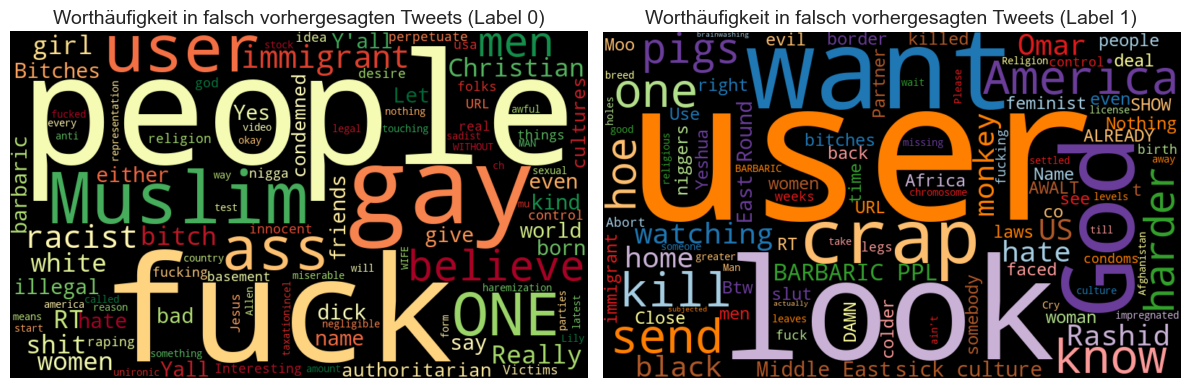

In [222]:
print_wordcloud(mostly_false_merged_manual1, tweet_col="tweet", label_col="label_manual")

#### 4.2 manuell gelabelte Tweets - Schwellwert 0.35

In [223]:
merged_false_manual2 = create_false_tweet_df(tweet_col="tweet", original_df=df_mixed_manual_uncleaned_new,
                                             threshold=0.35)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Prediction start.
Prediction finished.
Total Prediction took 0:00:56 (h:mm:ss)
Prediction start.
Prediction finished.
Total Prediction took 0:00:57 (h:mm:ss)


In [224]:
merged_false_manual2

,label_manual,tweet,0_ens,1_ens,pred_ens,0_nb,1_nb,pred_nb,0_svm,1_svm,...,pred_lstm,0_gru,1_gru,pred_gru,0_bert,1_bert,pred_bert,0_rob,1_rob,pred_rob
0,1,Post the shit or kill yourself faggot,0.06,0.94,1,0.104995,0.895005,1,0,0,...,1,0.011137,0.988863,1,0.180920,0.819080,1,0.192266,0.807734,1
2,1,i hate jews so much i wish the holocaust actua...,0.16,0.84,1,0.273041,0.726959,1,0,0,...,1,0.195016,0.804984,1,0.512623,0.487377,1,0.023317,0.976683,1
3,1,Poor kid would have been better off with his h...,0.48,0.52,1,0.343098,0.656902,1,0,0,...,1,0.036294,0.963706,1,0.157057,0.842943,1,0.221822,0.778178,1
10,1,"Close your fucking legs, hoe. Use birth contro...",0.60,0.40,1,0.527259,0.472741,1,0,0,...,1,0.006292,0.993708,1,0.713035,0.286965,0,0.158761,0.841239,1
11,1,@user @user Please take away their license to ...,0.70,0.30,0,0.450629,0.549371,1,0,0,...,0,0.997577,0.002423,0,0.865542,0.134458,0,0.961045,0.038955,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,wow men are fucking trash and disgusting,0.19,0.81,1,0.233985,0.766015,1,0,0,...,1,0.903850,0.096150,0,0.523429,0.476571,1,0.428509,0.571491,1
96,1,I hope your an anal only slut. No one should h...,0.17,0.83,1,0.258789,0.741211,1,0,0,...,1,0.012478,0.987522,1,0.265263,0.734737,1,0.052255,0.947745,1
97,1,do you have autism or something? why do you ta...,0.04,0.96,1,0.392299,0.607701,1,0,0,...,1,0.019523,0.980477,1,0.475986,0.524014,1,0.047550,0.952450,1
98,1,Stupid Asian Bitch You're an idiot and you sho...,0.20,0.80,1,0.160497,0.839503,1,0,0,...,1,0.011486,0.988514,1,0.222132,0.777868,1,0.057266,0.942734,1


In [225]:
all_false_merged_manual2 = get_all_false_merged(merged_false_manual2)
all_false_merged_manual2

Anzahl falsch vorhergesagter Tweets (von allen Modelle): 6


,label_manual,tweet,0_ens,1_ens,pred_ens,0_nb,1_nb,pred_nb,0_svm,1_svm,...,pred_lstm,0_gru,1_gru,pred_gru,0_bert,1_bert,pred_bert,0_rob,1_rob,pred_rob
66,0,RT @user: We Muslims have no military honour w...,0.46,0.54,1,0.214399,0.785601,1,0,0,...,1,0.006515,0.993485,1,0.596255,0.403745,1,0.008101,0.991899,1
2,0,"Those fucker give true muslims a bad name, kil...",0.22,0.78,1,0.255596,0.744404,1,0,0,...,1,0.424501,0.575499,1,0.241992,0.758008,1,0.036360,0.963640,1
12,0,Your gf is a whore I bet,0.21,0.79,1,0.114762,0.885238,1,0,0,...,1,0.036421,0.963579,1,0.297317,0.702683,1,0.039591,0.960409,1
15,0,Somebody find me this fucking pussy ass bitch URL,0.29,0.71,1,0.390066,0.609934,1,0,0,...,1,0.032229,0.967771,1,0.264960,0.735040,1,0.272777,0.727223,1
65,0,Get the fuck out stupid bitch,0.35,0.65,1,0.292034,0.707966,1,0,0,...,1,0.073379,0.926621,1,0.427763,0.572237,1,0.441481,0.558519,1
74,0,RT @user: Wat type of bitch ass nigga rape a i...,0.38,0.62,1,0.450220,0.549780,1,0,0,...,1,0.505137,0.494863,1,0.359640,0.640360,1,0.085985,0.914015,1


In [226]:
mostly_false_merged_manual2 = get_mostly_false_merged(merged_false_manual2)
mostly_false_merged_manual2

Anzahl falsch vorhergesagter Tweets (3/6 Modelle falsch): 67


,label_manual,tweet,0_ens,1_ens,pred_ens,0_nb,1_nb,pred_nb,0_svm,1_svm,...,0_gru,1_gru,pred_gru,0_bert,1_bert,pred_bert,0_rob,1_rob,pred_rob,preds
11,1,@user @user Please take away their license to ...,0.70,0.30,0,0.450629,0.549371,1,0,0,...,0.997577,0.002423,0,0.865542,0.134458,0,0.961045,0.038955,0,2
23,1,My God look at these BARBARIC PPL. And these p...,0.93,0.07,0,0.376031,0.623969,1,0,0,...,0.942953,0.057047,0,0.188737,0.811263,1,0.013796,0.986204,1,3
81,1,Man just wait till the US leaves Afghanistan s...,0.86,0.14,0,0.563057,0.436943,1,0,0,...,0.821766,0.178234,0,0.565452,0.434548,1,0.990371,0.009629,0,2
16,0,illegal immigrants =/= legal immigrants. in ev...,0.59,0.41,1,0.398594,0.601406,1,0,0,...,0.497590,0.502410,1,0.780791,0.219209,0,0.975723,0.024277,0,4
21,0,unironic incel parties will start to form. no ...,0.75,0.25,0,0.556272,0.443728,1,0,0,...,0.036047,0.963953,1,0.194741,0.805259,1,0.442455,0.557545,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,1,The Partner: *notices we're out of milk* The P...,0.92,0.08,0,0.200561,0.799439,1,0,0,...,0.009706,0.990294,1,0.503125,0.496875,1,0.978620,0.021380,0,3
63,1,What state got the best pussy? &#128064,0.84,0.16,0,0.412395,0.587605,1,0,0,...,0.998165,0.001835,0,0.933462,0.066538,0,0.985986,0.014014,0,1
66,1,@user You don't know what I know. Name somebod...,0.85,0.15,0,0.605034,0.394966,1,0,0,...,0.975001,0.024999,0,0.276314,0.723686,1,0.341612,0.658388,1,3
70,1,RT @user: Ô∏èObama swindling future generation...,0.82,0.18,0,0.514828,0.485172,1,0,0,...,0.979549,0.020451,0,0.956755,0.043245,0,0.831532,0.168468,0,1


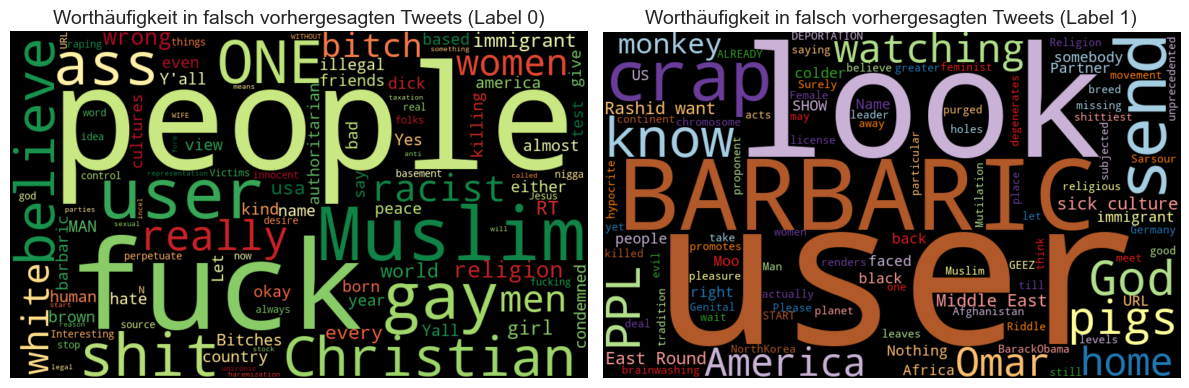

In [227]:
print_wordcloud(mostly_false_merged_manual2, tweet_col="tweet", label_col="label_manual")

#### 4.3 Mixed-Test cleaned - Schwellwert 0.5

In [228]:
df_mixed_test_cleaned = pd.read_csv("../../data/mixed_dataset/test_cleaned.csv", index_col=0)
df_mixed_test_cleaned = df_mixed_test_cleaned[df_mixed_test_cleaned.tweet_cleaned.notna()]

In [ ]:
merged_false_tweet_cleaned1 = create_false_tweet_df(tweet_col="tweet_cleaned", original_df=df_mixed_test_cleaned,
                                                    threshold=0.5)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Prediction start.


In [ ]:
merged_false_tweet_cleaned1

In [ ]:
all_false_merged_tweet_cleaned1 = get_all_false_merged(merged_false_tweet_cleaned1)
all_false_merged_tweet_cleaned1

In [ ]:
mostly_false_merged_tweet_cleaned1 = get_mostly_false_merged(merged_false_tweet_cleaned1)
mostly_false_merged_tweet_cleaned1

In [ ]:
print_wordcloud(mostly_false_merged_tweet_cleaned1, tweet_col="tweet", label_col="label_manual")

#### 4.4 Mixed-Test cleaned - Schwellwert 0.35

In [ ]:
merged_false_tweet_cleaned2 = create_false_tweet_df(tweet_col="tweet_cleaned", original_df=df_mixed_test_cleaned,
                                                    threshold=0.35)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Prediction start.


In [ ]:
merged_false_tweet_cleaned2

In [ ]:
all_false_merged_tweet_cleaned2 = get_all_false_merged(merged_false_tweet_cleaned2)
all_false_merged_tweet_cleaned2

In [ ]:
mostly_false_merged_tweet_cleaned2 = get_mostly_false_merged(merged_false_tweet_cleaned2)
mostly_false_merged_tweet_cleaned2

In [ ]:
print_wordcloud(mostly_false_merged_tweet_cleaned2, tweet_col="tweet", label_col="label_manual")